In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse, schedule

from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional, Union

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_7032/2268176252.py:19: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [3]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

In [45]:
# Acquisition Linspace Details

from helper_funcs.utils import *

acq_duration = 64

acq_latency_dt = get_closest_multiple_of_16(get_dt_from(320 * ns))
acq_latency_sec = acq_latency_dt * dt

init_time_sec = 50.0 * ns
total_duration_sec = get_closest_multiple_of_16(get_dt_from(450 * ns)) * dt

fine_kappas_linspace = np.linspace(init_time_sec, total_duration_sec, int(get_dt_from(total_duration_sec - init_time_sec) / acq_duration))
print(fine_kappas_linspace/ns)
print(len(fine_kappas_linspace))

[ 50.          64.87242798  79.74485597  94.61728395 109.48971193
 124.36213992 139.2345679  154.10699588 168.97942387 183.85185185
 198.72427984 213.59670782 228.4691358  243.34156379 258.21399177
 273.08641975 287.95884774 302.83127572 317.7037037  332.57613169
 347.44855967 362.32098765 377.19341564 392.06584362 406.9382716
 421.81069959 436.68312757 451.55555556]
28


In [5]:
def ss_acq_scan_exp(amp, fine_linspace):
    exp_g = []
    exp_e = []

    m_pulse = pulse.GaussianSquare(
        duration=measure_pulse.duration,
        amp=amp,
        sigma=measure_pulse.sigma,
        width=measure_pulse.width,
        angle=measure_pulse.angle,
        limit_amplitude=True
    )

    for kappa_delay_sec in fine_linspace:
        kappa_delay_dt = get_closest_multiple_of_16(get_dt_from(kappa_delay_sec))

        with pulse.build(backend=backend, default_alignment='left', name=f'acq scan g delay: {int(1e3*kappa_delay_sec/ns)/1e3}') as acq_g_sched:
            meas_chan = pulse.measure_channel(qubit)
            acq_chan = pulse.acquire_channel(qubit)

            pulse.delay(acq_latency_dt, meas_chan)
            pulse.play(m_pulse, meas_chan)
            pulse.delay(kappa_delay_dt, acq_chan)
            pulse.acquire(
                duration=acq_duration,
                qubit_or_channel=acq_chan,
                register=pulse.MemorySlot(qubit)
            )
        exp_g.append(acq_g_sched)
        
        with pulse.build(backend=backend, default_alignment='left', name=f'acq scan e delay: {int(1e3*kappa_delay_sec/ns)/1e3}') as acq_e_sched:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)
            acq_chan = pulse.acquire_channel(qubit)

            with pulse.align_right():
                pulse.delay(acq_latency_dt, meas_chan)
                pulse.play(x_pulse, qubit_chan)
            pulse.play(m_pulse, meas_chan)
            pulse.delay(kappa_delay_dt, acq_chan)
            pulse.acquire(
                duration=acq_duration,
                qubit_or_channel=acq_chan,
                register=pulse.MemorySlot(qubit)
            )
        exp_e.append(acq_e_sched)
    return exp_g, exp_e

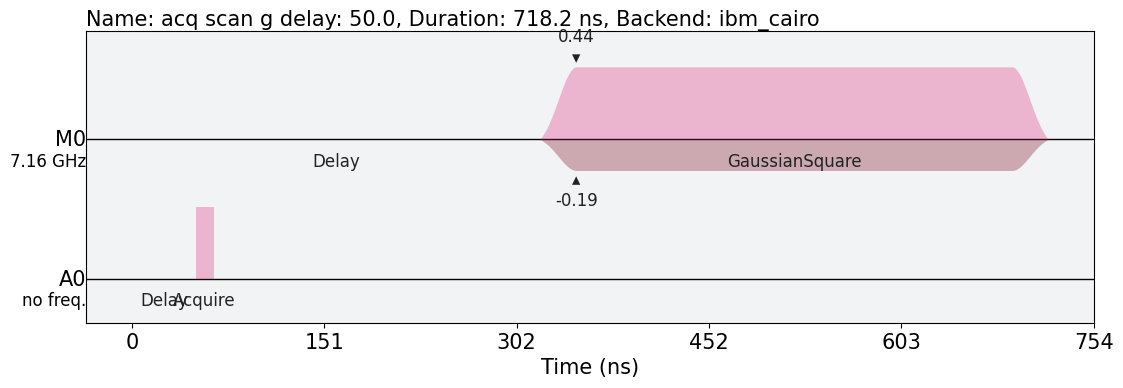

In [6]:
amps_linspace = np.linspace(0.04, 0.99, 25)

all_exp_g = []
all_exp_e = []

for amp in amps_linspace:
    temp_g, temp_e = ss_acq_scan_exp(amp, fine_linspace=fine_kappas_linspace)
    all_exp_g.append(temp_g)
    all_exp_e.append(temp_e)

batch_1_g = flatten(all_exp_g[:5])
batch_2_g = flatten(all_exp_g[5:10])
batch_3_g = flatten(all_exp_g[10:15])
batch_4_g = flatten(all_exp_g[15:20])
batch_5_g = flatten(all_exp_g[20:])

batch_1_e = flatten(all_exp_e[:5])
batch_2_e = flatten(all_exp_e[5:10])
batch_3_e = flatten(all_exp_e[10:15])
batch_4_e = flatten(all_exp_e[15:20])
batch_5_e = flatten(all_exp_e[20:])

batch_3_g[28].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

In [7]:
num_shots = 4096
rep_delay = 499.0 * 1e-6

exp_1 = batch_1_g + batch_1_e
exp_2 = batch_2_g + batch_2_e
exp_3 = batch_3_g + batch_3_e
exp_4 = batch_4_g + batch_4_e
exp_5 = batch_5_g + batch_5_e

acquisition_checker(exp_1)
acquisition_checker(exp_2)
acquisition_checker(exp_3)
acquisition_checker(exp_4)
acquisition_checker(exp_5)
print(len(exp_1))
print(len(exp_2))
print(len(exp_3))
print(len(exp_4))
print(len(exp_5))

280
280
280
280
280


In [17]:
# Running exp_1, exp_2, exp_3, exp_4, and exp_5

job_experiment = backend.run(exp_5, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued

KeyboardInterrupt: 

In [8]:
job_1 = provider.backend.retrieve_job('cp79fq6btqp0008f9grg')
job_2 = provider.backend.retrieve_job('cp79fyqmbjng0085eh20')
job_3 = provider.backend.retrieve_job('cp79g10ja3gg0080cxpg')
job_4 = provider.backend.retrieve_job('cp79g30mbjng0085eh30')
job_5 = provider.backend.retrieve_job('cp79g5rmbjng0085eh3g')

In [9]:
result_1 = get_results_arr(job_1.result(timeout=120), qubit=qubit)
result_2 = get_results_arr(job_2.result(timeout=120), qubit=qubit)
result_3 = get_results_arr(job_3.result(timeout=120), qubit=qubit)
result_4 = get_results_arr(job_4.result(timeout=120), qubit=qubit)
result_5 = get_results_arr(job_5.result(timeout=120), qubit=qubit)

In [10]:
print(result_1.shape)
print(result_2.shape)
print(result_3.shape)
print(result_4.shape)
print(result_5.shape)

(280, 4096)
(280, 4096)
(280, 4096)
(280, 4096)
(280, 4096)


In [11]:
result_1 = result_1.reshape(10, -1, num_shots)
result_2 = result_2.reshape(10, -1, num_shots)
result_3 = result_3.reshape(10, -1, num_shots)
result_4 = result_4.reshape(10, -1, num_shots)
result_5 = result_5.reshape(10, -1, num_shots)

result_1_g = result_1[:5]
result_1_e = result_1[5:]

result_2_g = result_2[:5]
result_2_e = result_2[5:]

result_3_g = result_3[:5]
result_3_e = result_3[5:]

result_4_g = result_4[:5]
result_4_e = result_4[5:]

result_5_g = result_5[:5]
result_5_e = result_5[5:]

big_results_g = np.concatenate((result_1_g, result_2_g, result_3_g, result_4_g, result_5_g), axis=0)
big_results_e = np.concatenate((result_1_e, result_2_e, result_3_e, result_4_e, result_5_e), axis=0)

In [12]:
big_fidelity = np.zeros((25, len(fine_kappas_linspace)))
big_sep_fidelity = np.zeros((25, len(fine_kappas_linspace)))

for ind, (res_g, res_e) in enumerate(zip(big_results_g, big_results_e)):
    print(res_g.shape)
    fidelity, sep_fidelity = get_fidelity(res_g, res_e)
    big_fidelity[ind] = fidelity
    big_sep_fidelity[ind] = sep_fidelity

(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)
(28, 4096)


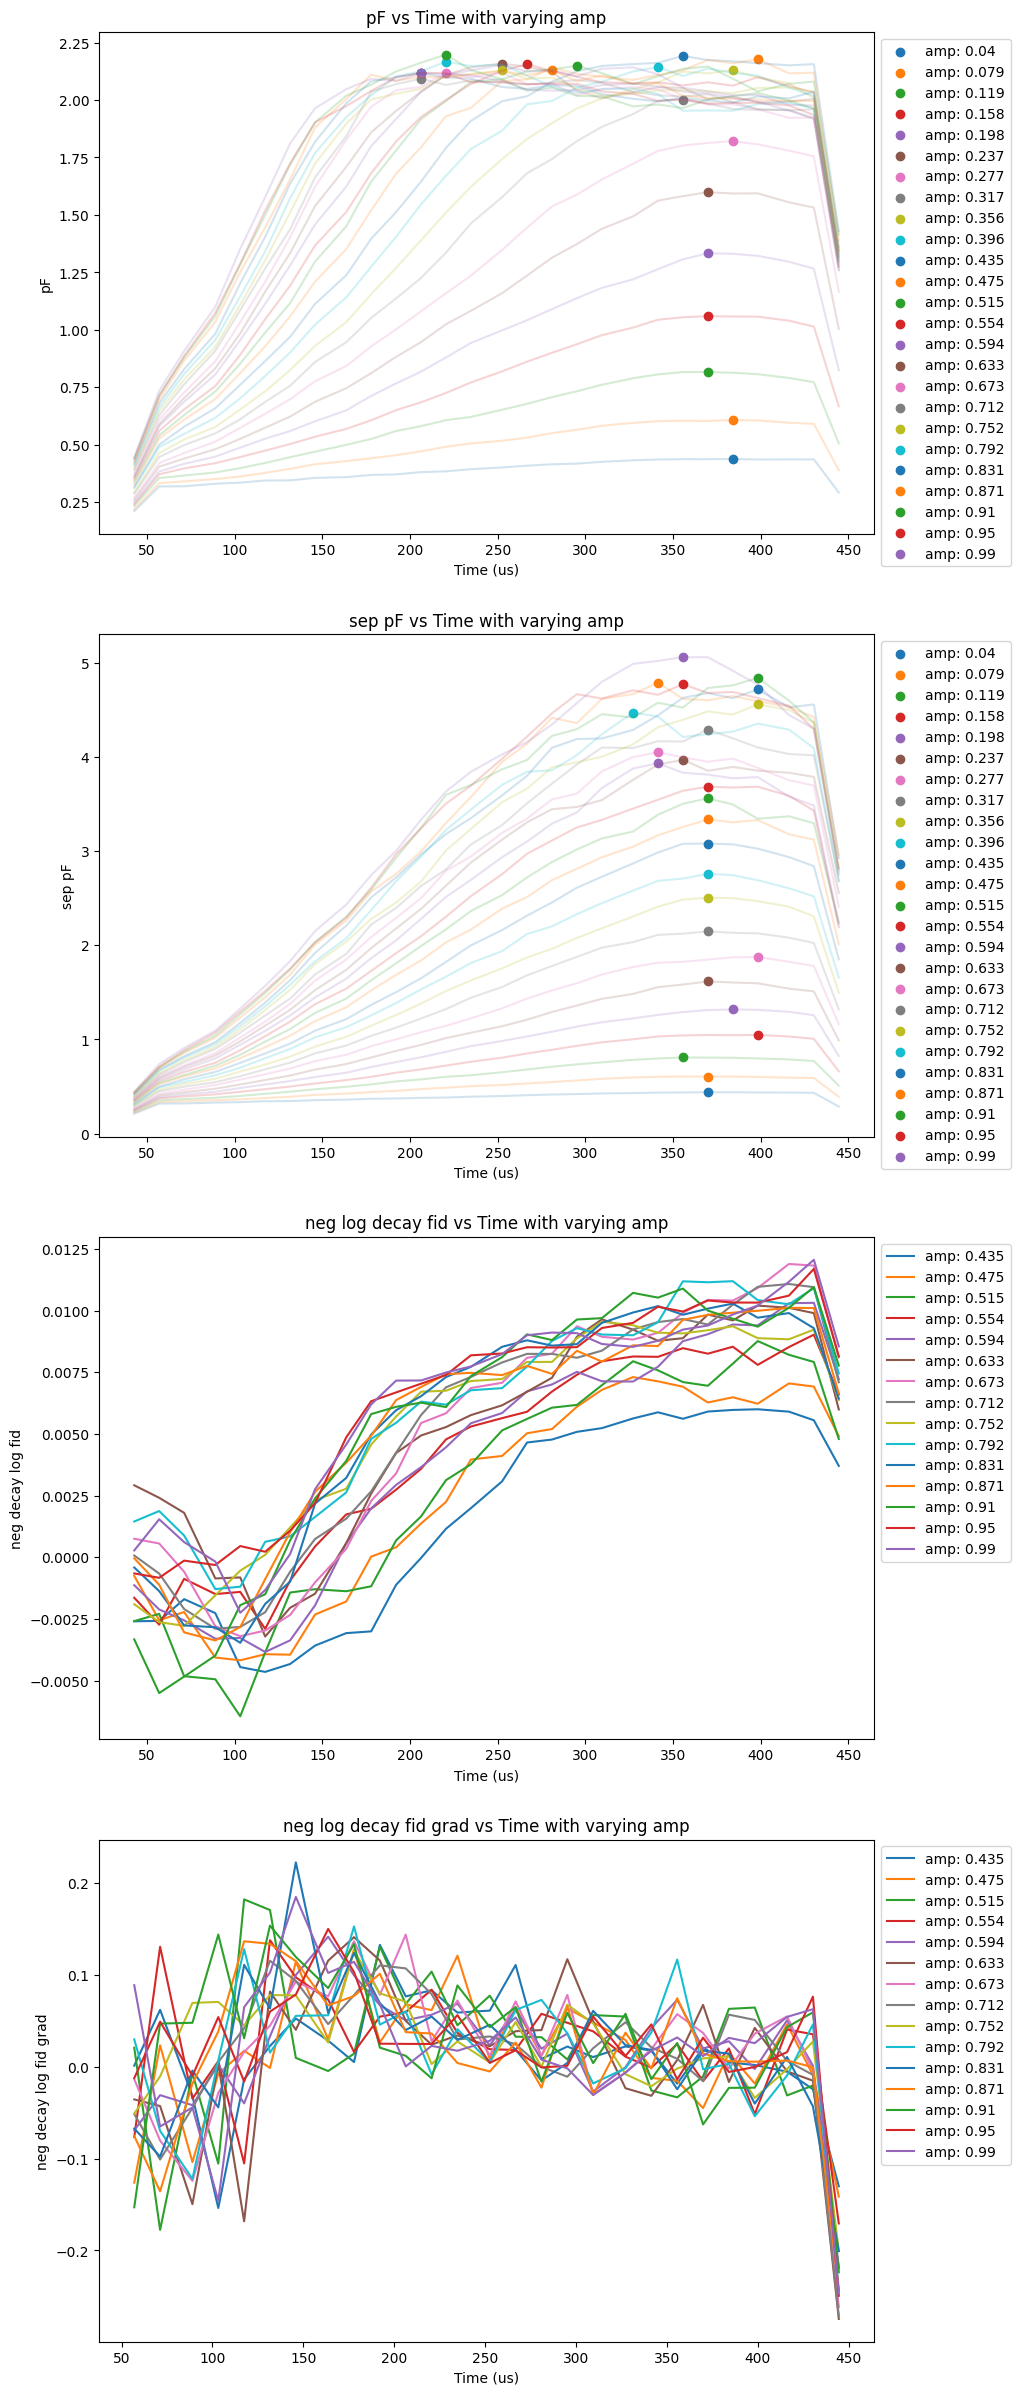

In [46]:
fine_kappas_linspace = np.linspace(init_time_sec, total_duration_sec, int(get_dt_from(total_duration_sec - init_time_sec) / acq_duration))
fine_kappas_linspace = np.round(fine_kappas_linspace/(16*dt))*16*dt - 7 * ns

big_pF = -np.log10(1. - big_fidelity)
big_sep_pF = -np.log10(1. - big_sep_fidelity)
big_decay_log_fidelity = -np.log(big_fidelity / big_sep_fidelity)

for i in range(len(big_pF)):
    big_pF[i] = np.convolve(big_pF[i], np.ones(3)/3, mode='same')
    big_sep_pF[i] = np.convolve(big_sep_pF[i], np.ones(3)/3, mode='same')
    big_decay_log_fidelity[i] = np.convolve(big_decay_log_fidelity[i], np.ones(3)/3, mode='same')
big_decay_grad = np.diff(big_decay_log_fidelity, axis=-1) / np.diff(fine_kappas_linspace/us)

max_pFs = np.max(big_pF, axis=-1)
ind_pFs = np.argmax(big_pF, axis=-1)
times_ns = fine_kappas_linspace[ind_pFs]/ns

max_sep_pFs = np.max(big_sep_pF, axis=-1)
ind_sep_pFs = np.argmax(big_sep_pF, axis=-1)
times_sep_ns = fine_kappas_linspace[ind_sep_pFs]/ns

fig, ax = plt.subplots(4, figsize=(10., 30.))

for ind, (pF_res, sep_pF_res, decay_log_fid) in enumerate(zip(big_pF, big_sep_pF, big_decay_log_fidelity)):
    ax[0].plot(fine_kappas_linspace/ns, pF_res, alpha=0.2)
    ax[0].scatter(times_ns[ind], max_pFs[ind], label=f'amp: {int(1e3*amps_linspace[ind])/1e3}')

    ax[1].plot(fine_kappas_linspace/ns, sep_pF_res, alpha=0.2)
    ax[1].scatter(times_sep_ns[ind], max_sep_pFs[ind], label=f'amp: {int(1e3*amps_linspace[ind])/1e3}')

    if ind > 9:
        ax[2].plot(fine_kappas_linspace/ns, decay_log_fid, alpha=1., label=f'amp: {int(1e3*amps_linspace[ind])/1e3}')
        ax[3].plot(fine_kappas_linspace[1:]/ns, big_decay_grad[ind,], alpha=1., label=f'amp: {int(1e3*amps_linspace[ind])/1e3}')

ax[0].legend(bbox_to_anchor=(1,1,))
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('pF')
ax[0].set_title('pF vs Time with varying amp')

ax[1].legend(bbox_to_anchor=(1,1,))
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('sep pF')
ax[1].set_title('sep pF vs Time with varying amp')

ax[2].legend(bbox_to_anchor=(1,1,))
ax[2].set_xlabel('Time (us)')
ax[2].set_ylabel('neg decay log fid')
ax[2].set_title('neg log decay fid vs Time with varying amp')

ax[3].legend(bbox_to_anchor=(1,1,))
ax[3].set_xlabel('Time (us)')
ax[3].set_ylabel('neg decay log fid grad')
ax[3].set_title('neg log decay fid grad vs Time with varying amp')

plt.show()

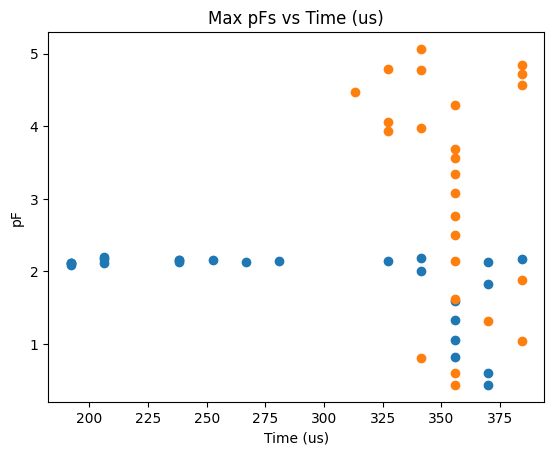

In [26]:
plt.scatter(times_ns, max_pFs, label='pF')
plt.scatter(times_sep_ns, max_sep_pFs, label='sep pF')
plt.xlabel('Time (us)')
plt.ylabel('pF')
plt.title('Max pFs vs Time (us)')
plt.show()

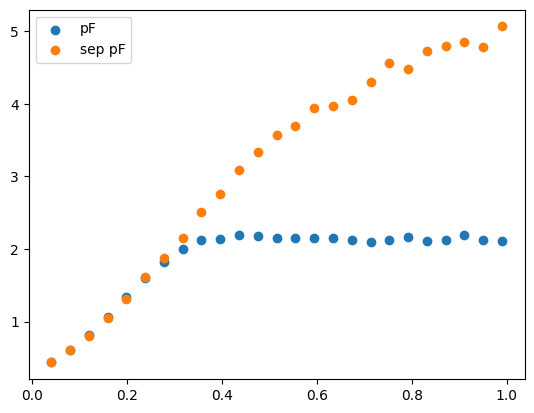

In [27]:
plt.scatter(amps_linspace, max_pFs, label='pF')
plt.scatter(amps_linspace, max_sep_pFs, label='sep pF')
plt.legend()
plt.show()

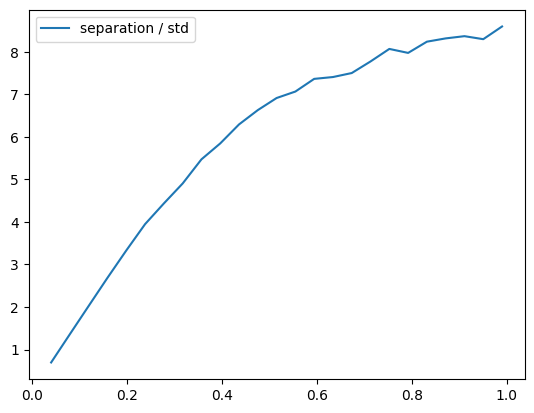

In [28]:
from scipy.special import erfinv

separations = erfinv(2 * (1 - 10**(-big_sep_pF)) - 1) * 2 * np.sqrt(2)

plt.plot(amps_linspace, np.max(separations, axis=-1), label='separation / std')
plt.legend()
plt.show()

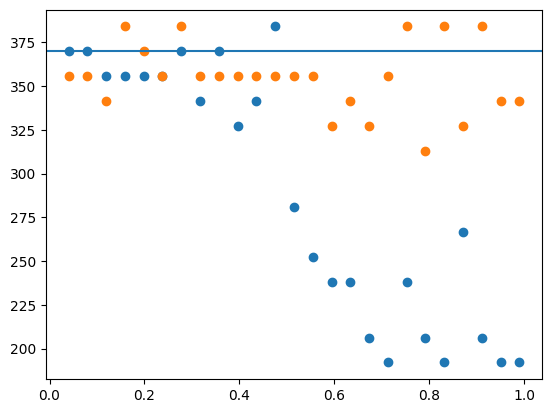

In [29]:
plt.scatter(amps_linspace, times_ns, label='pF times')
plt.scatter(amps_linspace, times_sep_ns, label='sep pF times')
plt.axhline(y=370)
plt.show()